# Steric optimization for the North Sea

In [1]:
import sys
sys.path.append('../code')
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import SeaLevelContrib as slc

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [59]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '../code/SeaLevelContrib.py'>

In [2]:
data_path = '../outputs/'

In [3]:
b_df = pd.read_csv(f'{data_path}slbudget_2021_12_06_NS_Fred16_1950_2020_ERA5StericIAP_500m.csv')
b_df = b_df.set_index('time')

In [4]:
b_df

,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
1950,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.902359
1951,-4.146598,-3.460850,0.097124,0.00525,0.048333,0.005000,-0.001250,0.290417,0.008253,-1.193756,0.054880,0.702359
1952,-2.481783,-2.161335,0.176444,0.01050,0.107500,0.010417,-0.002083,0.284167,-0.054336,-0.414208,-0.438848,2.012359
1953,-4.142491,-1.704739,0.177486,0.01575,0.172083,0.015000,-0.001667,0.276667,-0.180699,-0.374800,-2.537571,0.772359
1954,0.662590,-0.463084,0.193522,0.02100,0.222917,0.020417,-0.002500,0.165833,-0.356571,0.711085,0.149971,1.392359
...,...,...,...,...,...,...,...,...,...,...,...,...
2016,1.733211,-2.556120,4.680546,0.34650,2.369583,0.850000,-0.042917,-0.073750,-1.249658,-1.040441,-1.550532,8.854070
2017,6.176883,-1.279697,4.838131,0.35175,2.434167,0.865000,-0.042500,-0.545000,-1.196393,1.418693,-0.667268,12.391570
2018,1.033709,-1.990038,4.889651,0.35700,2.451250,0.975000,-0.035000,-0.685417,-1.077951,-2.022615,-1.828171,7.110848


In [7]:
st = slc.StericSL(0, 500, 'ENS', 'IAP')
st = st.loc[1950:] - st.loc[1950]
st

,Steric
time,
1950,0.000000
1951,-3.363726
1952,-1.984891
1953,-1.527254
1954,-0.269562
...,...
2016,2.124426
2017,3.558434
2018,2.899613


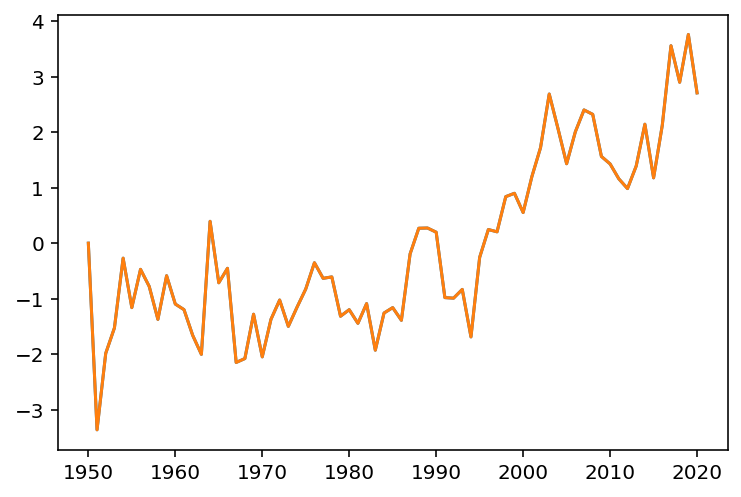

In [8]:
plt.plot(b_df['LocSteric']+b_df['GloSteric'])
plt.plot(st)

In [9]:
nt = b_df.loc[:,'GIA':'Pressure'].sum(axis=1) + st.Steric
nt

time
1950    0.000000
1951   -4.146598
1952   -2.481783
1953   -4.142491
1954    0.662590
          ...   
2016    1.733211
2017    6.176883
2018    1.033709
2019    5.418139
2020    6.953814
Length: 71, dtype: float64

In [10]:
b_df.Total

time
1950    0.000000
1951   -4.146598
1952   -2.481783
1953   -4.142491
1954    0.662590
          ...   
2016    1.733211
2017    6.176883
2018    1.033709
2019    5.418139
2020    6.953814
Name: Total, Length: 71, dtype: float64

### One layer model

In [19]:
depth_range = np.arange(100,2100,100)
product = 'EN4' # IAP, EN4

try:
    del(full_error_df)
except:
    print('full_error_df not yet defined')
    
if product == 'IAP':
    loc_b_df = b_df.copy()
elif product == 'EN4':
    loc_b_df = b_df[:-2].copy()

for reg in ['ENS', 'EBB', 'NWS']:
    for window in range(1,13,2):
        print(f'Starting region {reg} with window {window}')
        
        error_df = pd.DataFrame(columns=['Depth', f'RMSE_{reg}_{window}', 
                                         f'AE_{reg}_{window}',
                                         f'linear_{reg}_{window}'])
        error_df['Depth'] = depth_range
        error_df = error_df.set_index('Depth')

        if window > 1:
            smoothing = True
            frac = window/error_df.shape[0]
        else:
            smoothing = False

        for d in depth_range:
            st = slc.StericSL(0, d, reg, product)
            st = st.loc[1950:] - st.loc[1950]
            if smoothing:
                st['Steric'] = lowess(st['Steric'], st.index, frac, return_sorted=False)
            nt = loc_b_df.loc[:,'GIA':'Pressure'].sum(axis=1) + st.Steric
            diff_df = loc_b_df.Obs - nt
            diff_df = diff_df - diff_df.mean()
            RMSE = np.sqrt( (diff_df**2).sum() ) / len(diff_df)
            AE = np.abs(diff_df).sum() / len(diff_df)
            lin_trend = np.polyfit(diff_df.index, 
                                   diff_df * 10, 1)[0]  # Convert from cm to mm
            error_df.loc[d] = [RMSE, AE, lin_trend]

        if 'full_error_df' in locals():
            full_error_df = full_error_df.join(error_df)
        else:
            full_error_df = error_df.copy()

Starting region ENS with window 1
lin_trend:
0.7079291370625949
lin_trend:
0.6219450732490522
lin_trend:
0.5590233076047627
lin_trend:
0.5041415481547133
lin_trend:
0.46263203202841546
lin_trend:
0.42711336012893436
lin_trend:
0.40381941416962336
lin_trend:
0.40106049816315753
lin_trend:
0.40106049816315753
lin_trend:
0.36992900083912983
lin_trend:
0.36992900083912983
lin_trend:
0.3215175376264645
lin_trend:
0.3215175376264645
lin_trend:
0.256493761919729
lin_trend:
0.256493761919729
lin_trend:
0.256493761919729
lin_trend:
0.21724160802955766
lin_trend:
0.21724160802955766
lin_trend:
0.1586823896637099
lin_trend:
0.1586823896637099
Starting region ENS with window 3
lin_trend:
0.7064422470810209
lin_trend:
0.6324827044457756
lin_trend:
0.5673198423657312
lin_trend:
0.5190736453493875
lin_trend:
0.48745712644745515
lin_trend:
0.45219537722702063
lin_trend:
0.43155647803472386
lin_trend:
0.43565437990375333
lin_trend:
0.43565437990375333
lin_trend:
0.4250396085972373
lin_trend:
0.42503960

In [22]:
#full_error_df.to_csv('../outputs/steric_optimization_EN4_1layer.csv')

In [12]:
error_IAP_df = pd.read_csv('../outputs/steric_optimization_IAP_1layer.csv')
error_IAP_df.set_index('Depth', inplace=True)
error_IAP_df

,RMSE_ENS_1,AE_ENS_1,linear_ENS_1,RMSE_ENS_3,AE_ENS_3,linear_ENS_3,RMSE_ENS_5,AE_ENS_5,linear_ENS_5,RMSE_ENS_7,...,linear_NWS_5,RMSE_NWS_7,AE_NWS_7,linear_NWS_7,RMSE_NWS_9,AE_NWS_9,linear_NWS_9,RMSE_NWS_11,AE_NWS_11,linear_NWS_11
Depth,,,,,,,,,,,,,,,,,,,,,
100,0.238950,1.666888,0.687259,0.248360,1.723904,0.690036,0.250253,1.735310,0.688410,0.252183,...,0.659746,0.254794,1.774255,0.663305,0.255380,1.781141,0.666071,0.254987,1.775997,0.663911
200,0.207156,1.421878,0.538561,0.217349,1.475104,0.540149,0.220068,1.487711,0.541965,0.224061,...,0.501222,0.234276,1.615397,0.506254,0.234652,1.615130,0.509647,0.233403,1.599667,0.506303
300,0.189919,1.296034,0.430700,0.198901,1.340978,0.445625,0.201302,1.354958,0.444306,0.205702,...,0.409011,0.226469,1.550536,0.418230,0.226409,1.542940,0.423320,0.224935,1.526205,0.421261
400,0.180335,1.218144,0.339554,0.185671,1.243430,0.359465,0.188650,1.266520,0.366940,0.192679,...,0.380359,0.228211,1.564197,0.388458,0.227448,1.552888,0.394302,0.225352,1.530063,0.392921
500,0.176162,1.195957,0.241878,0.175703,1.167621,0.189113,0.176982,1.187824,0.257493,0.181829,...,0.368120,0.231405,1.588987,0.375925,0.230688,1.579337,0.381210,0.227689,1.548681,0.379688
600,0.175134,1.178231,0.173700,0.172503,1.153574,0.112920,0.171586,1.153823,0.185872,0.175784,...,0.369693,0.233656,1.606295,0.376103,0.232641,1.595161,0.380367,0.229543,1.564440,0.379333
700,0.174299,1.175195,0.125624,0.171856,1.156172,0.059244,0.168729,1.140439,0.115707,0.173064,...,0.377525,0.235379,1.619725,0.381634,0.233307,1.600835,0.383941,0.229798,1.568685,0.382294
800,0.174700,1.171356,0.086477,0.172347,1.163808,0.019183,0.169365,1.152299,0.050651,0.172087,...,0.377951,0.235319,1.619861,0.380031,0.232695,1.597124,0.381452,0.228525,1.559180,0.379162
900,0.176217,1.171658,0.058183,0.172865,1.171455,0.000461,0.170263,1.165349,0.038760,0.172293,...,0.366077,0.232219,1.595618,0.366794,0.229693,1.575821,0.368150,0.225848,1.539397,0.367386


In [23]:
error_EN4_df = pd.read_csv('../outputs/steric_optimization_EN4_1layer.csv')
error_EN4_df.set_index('Depth', inplace=True)
error_EN4_df

,RMSE_ENS_1,AE_ENS_1,linear_ENS_1,RMSE_ENS_3,AE_ENS_3,linear_ENS_3,RMSE_ENS_5,AE_ENS_5,linear_ENS_5,RMSE_ENS_7,...,linear_NWS_5,RMSE_NWS_7,AE_NWS_7,linear_NWS_7,RMSE_NWS_9,AE_NWS_9,linear_NWS_9,RMSE_NWS_11,AE_NWS_11,linear_NWS_11
Depth,,,,,,,,,,,,,,,,,,,,,
100,0.244360,1.659572,0.707929,0.253008,1.728779,0.706442,0.255639,1.742740,0.707642,0.258685,...,0.685722,0.261999,1.795896,0.695122,0.261946,1.798222,0.695444,0.261223,1.793919,0.691929
200,0.222993,1.491908,0.621945,0.233887,1.579651,0.632483,0.237467,1.593137,0.631619,0.242278,...,0.570208,0.245968,1.652157,0.586371,0.245348,1.653876,0.585955,0.243925,1.648468,0.579745
300,0.207732,1.380511,0.559023,0.217727,1.462386,0.567320,0.222936,1.480127,0.570486,0.229724,...,0.498284,0.237931,1.580849,0.517507,0.237151,1.582836,0.518184,0.235303,1.573881,0.510641
400,0.197484,1.308854,0.504142,0.206176,1.380975,0.519074,0.212030,1.398176,0.521298,0.219512,...,0.439448,0.236089,1.553016,0.464107,0.234664,1.551380,0.464970,0.232284,1.545554,0.456551
500,0.192219,1.269175,0.462632,0.200461,1.335823,0.487457,0.206755,1.358324,0.492791,0.213666,...,0.399901,0.236185,1.544931,0.422184,0.233885,1.538678,0.421730,0.231097,1.529259,0.412273
600,0.188823,1.250568,0.427113,0.195198,1.295761,0.452195,0.203591,1.334164,0.474672,0.210572,...,0.384747,0.235959,1.542903,0.407632,0.233795,1.536020,0.407646,0.230758,1.525311,0.397973
700,0.190226,1.244648,0.403819,0.193269,1.281928,0.431556,0.206166,1.354679,0.487460,0.214093,...,0.333027,0.231161,1.514457,0.357575,0.228562,1.491716,0.357640,0.225593,1.481217,0.347853
800,0.194789,1.261715,0.401060,0.196834,1.311284,0.435654,0.210865,1.384769,0.498627,0.215108,...,0.300043,0.226864,1.489230,0.324762,0.224645,1.465399,0.326840,0.221671,1.449457,0.317426
900,0.194789,1.261715,0.401060,0.196834,1.311284,0.435654,0.210865,1.384769,0.498627,0.215108,...,0.300043,0.226864,1.489230,0.324762,0.224645,1.465399,0.326840,0.221671,1.449457,0.317426


### Two layer model

In [86]:
windows = np.array([5, 15])

depth_range = np.arange(50,2050,50)

error_df = pd.DataFrame(columns=['Depth', 'RMSE', 'AE'])
error_df['Depth'] = depth_range
error_df = error_df.set_index('Depth')

smoothing = True
frac = windows/error_df.shape[0]

for d in depth_range:
    print(d)
    
    st1 = slc.StericSL(0, d, 'ENS', 'IAP')
    st1['Steric'] = lowess(st1['Steric'], st1.index, frac[0], return_sorted=False)
    
    st2 = slc.StericSL(d, 2000, 'ENS', 'IAP')
    st2['Steric'] = lowess(st2['Steric'], st2.index, frac[1], return_sorted=False)
    
    st = st1+st2
    st = st.loc[1950:] - st.loc[1950]

    nt = b_df.loc[:,'GIA':'Pressure'].sum(axis=1) + st.Steric
    diff_df = b_df.Obs - nt
    diff_df = diff_df - diff_df.mean()
    RMSE = np.sqrt( (diff_df**2).sum() ) / len(diff_df)
    AE = np.abs(diff_df).sum() / len(diff_df)
    error_df.loc[d] = [RMSE, AE]
    

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000


In [87]:
frac

array([0.125, 0.375])

### First results without smoothing

<AxesSubplot:xlabel='Depth'>

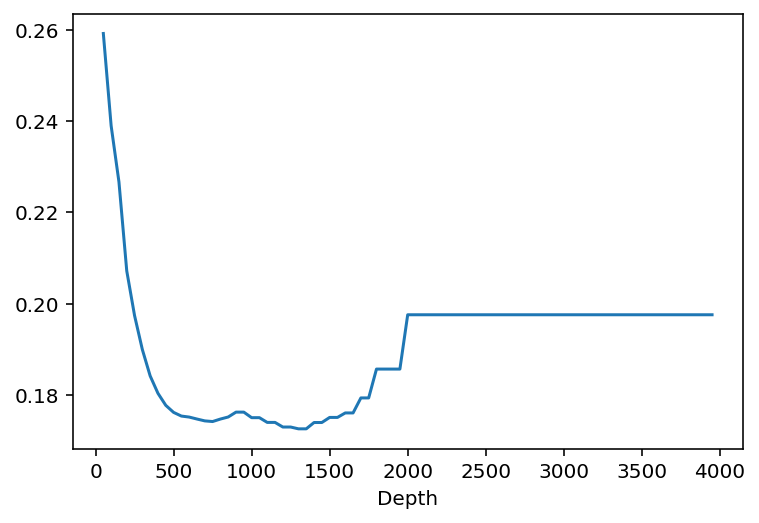

In [54]:
error_df['RMSE'].plot()


<AxesSubplot:xlabel='Depth'>

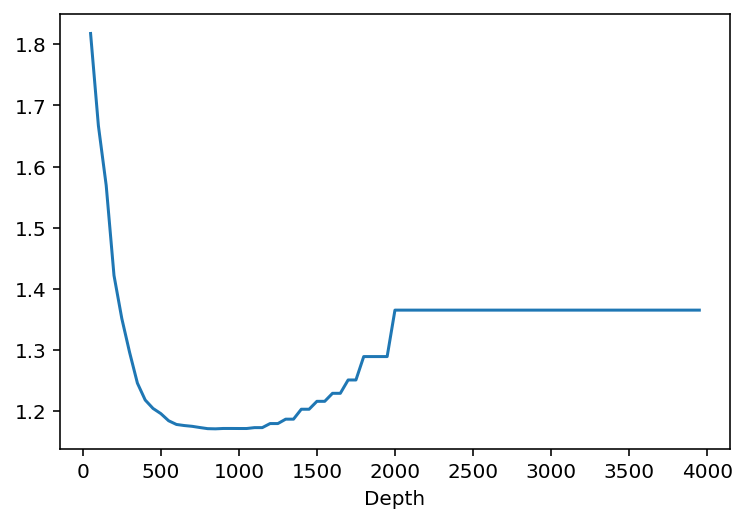

In [55]:
error_df['AE'].plot()

### Result with smoothing window of 3 y

<AxesSubplot:xlabel='Depth'>

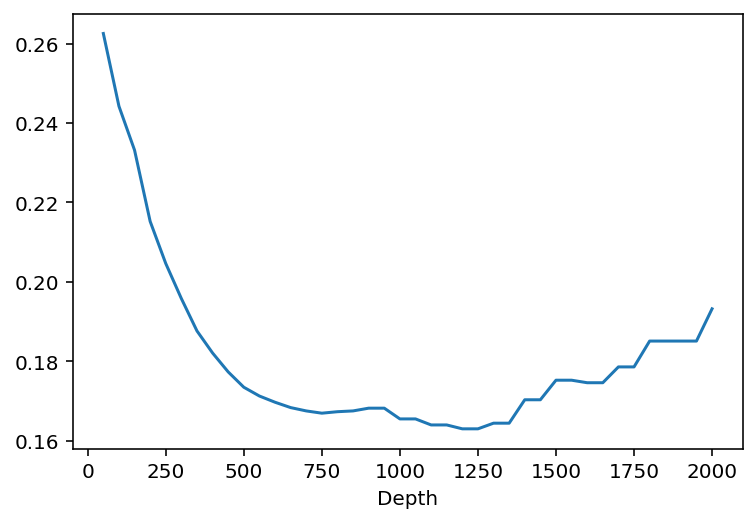

In [73]:
error_df['RMSE'].plot()

<AxesSubplot:xlabel='Depth'>

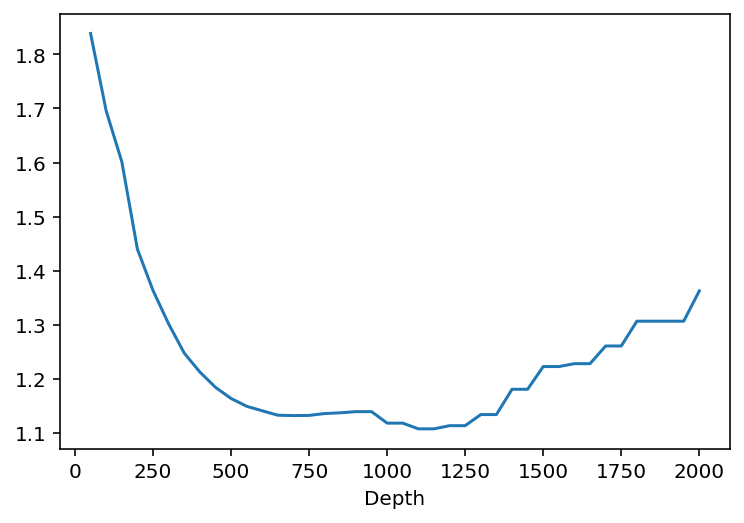

In [74]:
error_df['AE'].plot()

### Smoothing window is 5 years

<AxesSubplot:xlabel='Depth'>

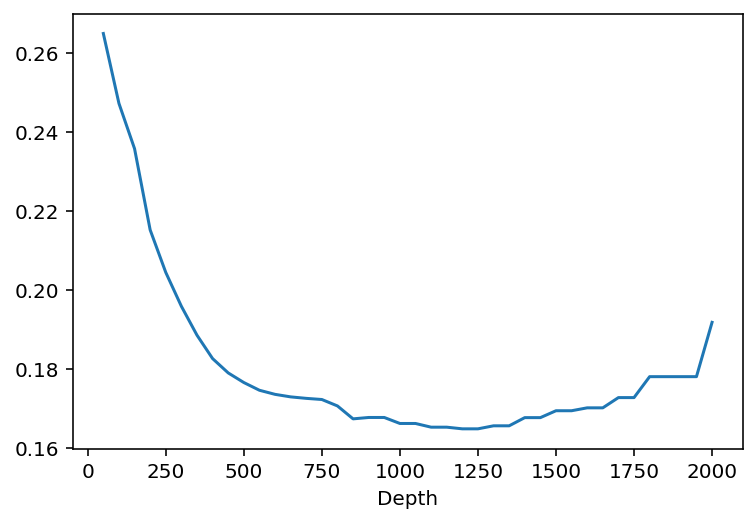

In [76]:
error_df['RMSE'].plot()

<AxesSubplot:xlabel='Depth'>

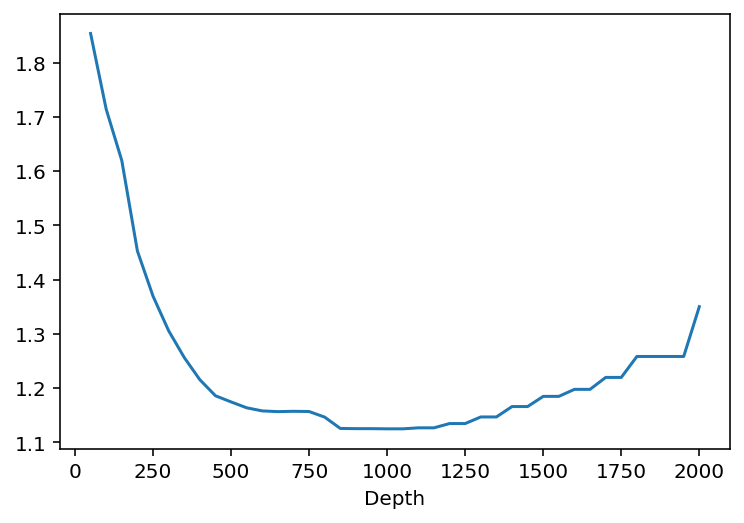

In [77]:
error_df['AE'].plot()

### Smoothing 7 years

<AxesSubplot:xlabel='Depth'>

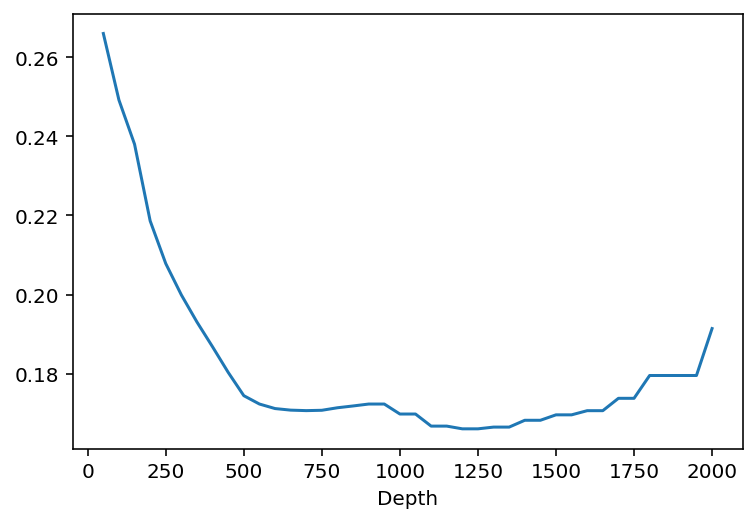

In [79]:
error_df['RMSE'].plot()

<AxesSubplot:xlabel='Depth'>

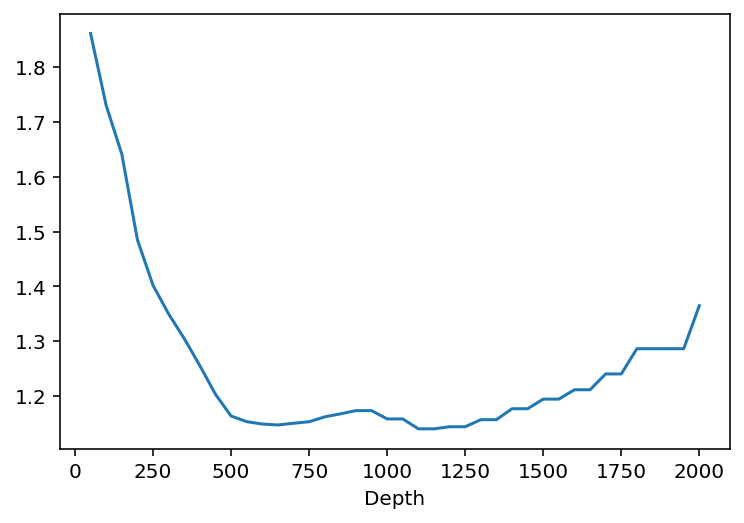

In [80]:
error_df['AE'].plot()

### 2 layer model: 5, 15

<AxesSubplot:xlabel='Depth'>

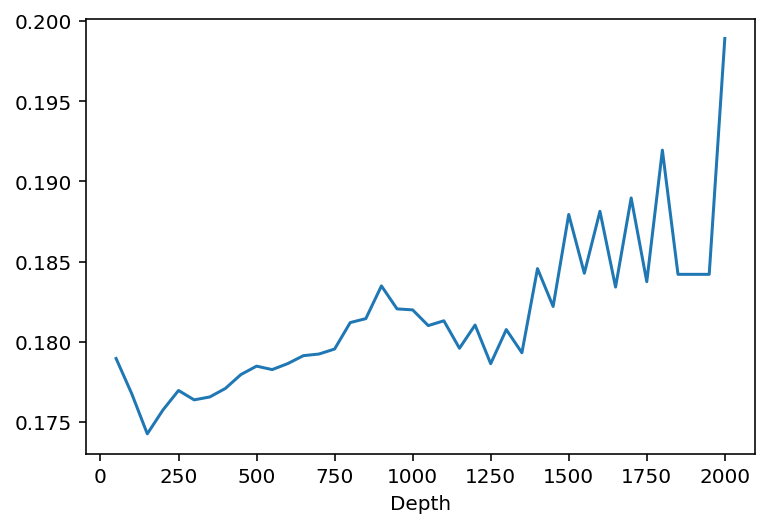

In [89]:
error_df['RMSE'].plot()

<AxesSubplot:xlabel='Depth'>

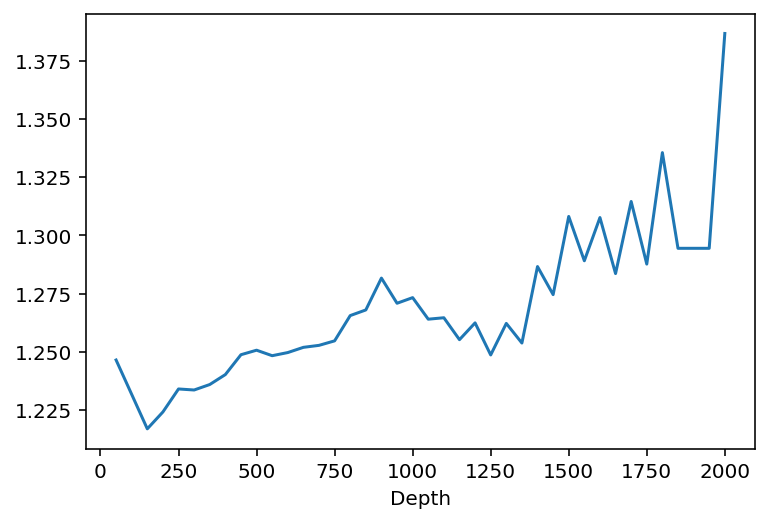

In [90]:
error_df['AE'].plot()

In [111]:
error_IAP_df

,RMSE_ENS_1,AE_ENS_1,linear_ENS_1,RMSE_ENS_3,AE_ENS_3,linear_ENS_3,RMSE_ENS_5,AE_ENS_5,linear_ENS_5,RMSE_ENS_7,...,linear_NWS_5,RMSE_NWS_7,AE_NWS_7,linear_NWS_7,RMSE_NWS_9,AE_NWS_9,linear_NWS_9,RMSE_NWS_11,AE_NWS_11,linear_NWS_11
Depth,,,,,,,,,,,,,,,,,,,,,
100,0.238950,1.666888,0.687259,0.248360,1.723904,0.690036,0.250253,1.735310,0.688410,0.252183,...,0.688410,0.252183,1.746455,0.691435,0.253777,1.757779,0.695217,0.254240,1.764532,0.693918
200,0.207156,1.421878,0.538561,0.217349,1.475104,0.540149,0.220068,1.487711,0.541965,0.224061,...,0.541965,0.224061,1.508925,0.549166,0.226806,1.528959,0.557443,0.227272,1.537652,0.553004
300,0.189919,1.296034,0.430700,0.198901,1.340978,0.445625,0.201302,1.354958,0.444306,0.205702,...,0.444306,0.205702,1.368007,0.449912,0.208487,1.383500,0.458529,0.208988,1.389073,0.453299
400,0.180335,1.218144,0.339554,0.185671,1.243430,0.359465,0.188650,1.266520,0.366940,0.192679,...,0.366940,0.192679,1.285755,0.370171,0.194805,1.297208,0.375412,0.195271,1.300570,0.370005
500,0.176162,1.195957,0.241878,0.175703,1.167621,0.189113,0.176982,1.187824,0.257493,0.181829,...,0.257493,0.181829,1.208642,0.267504,0.183662,1.219471,0.272395,0.184197,1.223300,0.264195
600,0.175134,1.178231,0.173700,0.172503,1.153574,0.112920,0.171586,1.153823,0.185872,0.175784,...,0.185872,0.175784,1.174130,0.197100,0.177284,1.181878,0.200140,0.177962,1.187691,0.193892
700,0.174299,1.175195,0.125624,0.171856,1.156172,0.059244,0.168729,1.140439,0.115707,0.173064,...,0.115707,0.173064,1.166539,0.142252,0.174285,1.168990,0.144176,0.175049,1.177278,0.135804
800,0.174700,1.171356,0.086477,0.172347,1.163808,0.019183,0.169365,1.152299,0.050651,0.172087,...,0.050651,0.172087,1.169825,0.090935,0.173022,1.171282,0.095415,0.173769,1.179701,0.088018
900,0.176217,1.171658,0.058183,0.172865,1.171455,0.000461,0.170263,1.165349,0.038760,0.172293,...,0.038760,0.172293,1.178089,0.066952,0.172764,1.178626,0.068050,0.173418,1.185779,0.059747


<AxesSubplot:xlabel='Depth'>

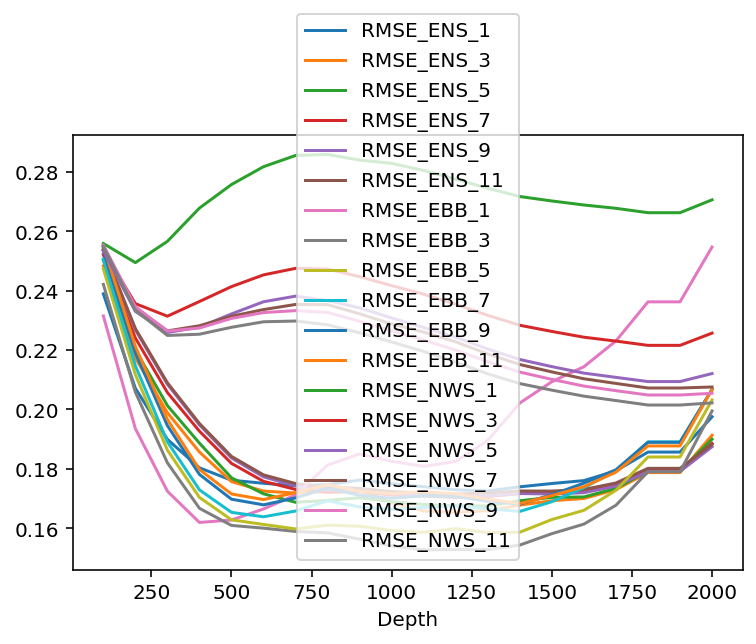

In [120]:
error_IAP_df.filter(like='RMSE').plot()

In [121]:
error_IAP_df.filter(like='RMSE').min()

RMSE_ENS_1     0.172557
RMSE_ENS_3     0.165359
RMSE_ENS_5     0.167504
RMSE_ENS_7     0.170371
RMSE_ENS_9     0.170669
RMSE_ENS_11    0.171532
RMSE_EBB_1     0.161939
RMSE_EBB_3     0.152715
RMSE_EBB_5     0.158530
RMSE_EBB_7     0.163849
RMSE_EBB_9     0.167867
RMSE_EBB_11    0.168301
RMSE_NWS_1     0.249478
RMSE_NWS_3     0.221599
RMSE_NWS_5     0.209402
RMSE_NWS_7     0.207235
RMSE_NWS_9     0.204872
RMSE_NWS_11    0.201500
dtype: float64

In [123]:
error_IAP_df.filter(like='AE').min()

AE_ENS_1     1.171356
AE_ENS_3     1.130133
AE_ENS_5     1.140439
AE_ENS_7     1.166539
AE_ENS_9     1.168990
AE_ENS_11    1.177278
AE_EBB_1     1.035186
AE_EBB_3     1.015667
AE_EBB_5     1.083718
AE_EBB_7     1.135117
AE_EBB_9     1.173698
AE_EBB_11    1.178892
AE_NWS_1     1.747034
AE_NWS_3     1.506065
AE_NWS_5     1.402831
AE_NWS_7     1.400262
AE_NWS_9     1.376667
AE_NWS_11    1.354868
dtype: float64

In [125]:
error_IAP_df.filter(like='linear')

linear_ENS_1    -0.345933
linear_ENS_3    -0.335152
linear_ENS_5    -0.333546
linear_ENS_7    -0.315376
linear_ENS_9    -0.317905
linear_ENS_11   -0.324469
linear_EBB_1    -0.559018
linear_EBB_3    -0.512764
linear_EBB_5    -0.513545
linear_EBB_7    -0.519772
linear_EBB_9    -0.524674
linear_EBB_11   -0.523103
linear_NWS_1     0.062478
linear_NWS_3     0.049681
linear_NWS_5     0.043073
linear_NWS_7     0.047914
linear_NWS_9     0.054937
linear_NWS_11    0.058930
dtype: float64

In [128]:
error_IAP_df['AE_EBB_3'] #.plot()

Depth
100     1.687117
200     1.425087
300     1.214005
400     1.071755
500     1.037851
600     1.053814
700     1.052458
800     1.039080
900     1.023273
1000    1.024208
1100    1.015667
1200    1.016563
1300    1.018877
1400    1.026210
1500    1.046463
1600    1.065588
1700    1.115478
1800    1.199618
1900    1.199618
2000    1.336895
Name: AE_EBB_3, dtype: float64

In [211]:
error_IAP_df['linear_ENS_3']

Depth
100     0.690036
200     0.540149
300     0.445625
400     0.359465
500     0.189113
600     0.112920
700     0.059244
800     0.019183
900     0.000461
1000    0.014398
1100    0.036510
1200    0.022711
1300   -0.000912
1400   -0.038548
1500   -0.075219
1600   -0.124190
1700   -0.175229
1800   -0.248050
1900   -0.248050
2000   -0.335152
Name: linear_ENS_3, dtype: float64

### Check diff for the two minima

In [207]:
# 500, 1100
d = 1000
window = 3
smoothing = True
reg = 'EBB'
#product = 'EN4'

frac = window/error_df.shape[0]

st1 = slc.StericSL(0, d, reg, 'IAP')
st1 = st1.loc[1950:] - st1.loc[1950]

st2 = slc.StericSL(0, d, reg, 'EN4')
st2 = st2.loc[1950:] - st2.loc[1950]

st = (st1+st2)/2

if smoothing:
    st['Steric'] = lowess(st['Steric'], st.index, frac, return_sorted=False)
nt = b_df.loc[:,'GIA':'Pressure'].sum(axis=1) + st.Steric
diff_df = b_df.Obs - nt
diff_df = diff_df - diff_df.mean()

<AxesSubplot:xlabel='time'>

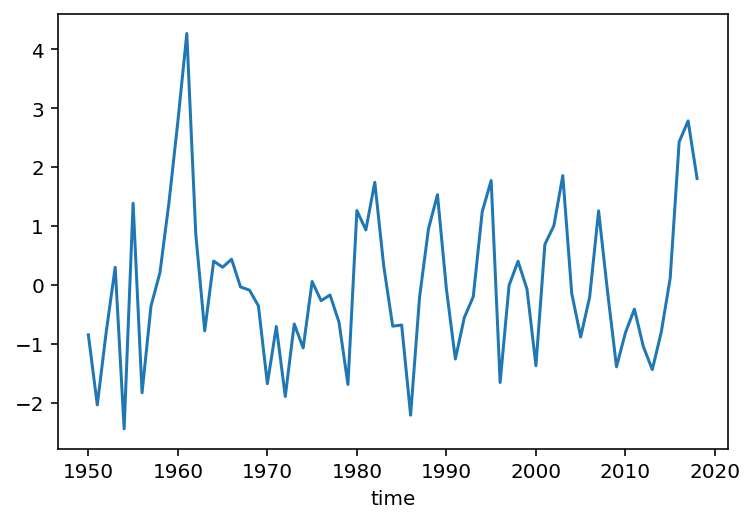

In [208]:
diff_df.plot()

<AxesSubplot:xlabel='time'>

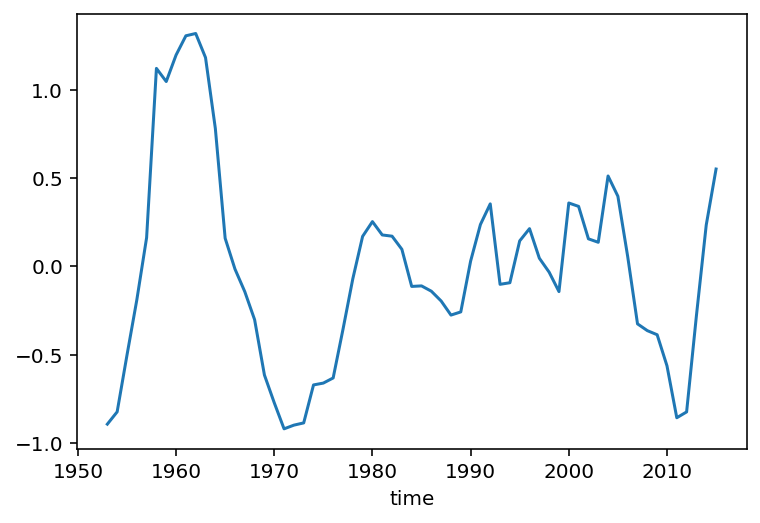

In [209]:
diff_df.rolling(7,center=True).mean().plot()

<AxesSubplot:xlabel='time'>

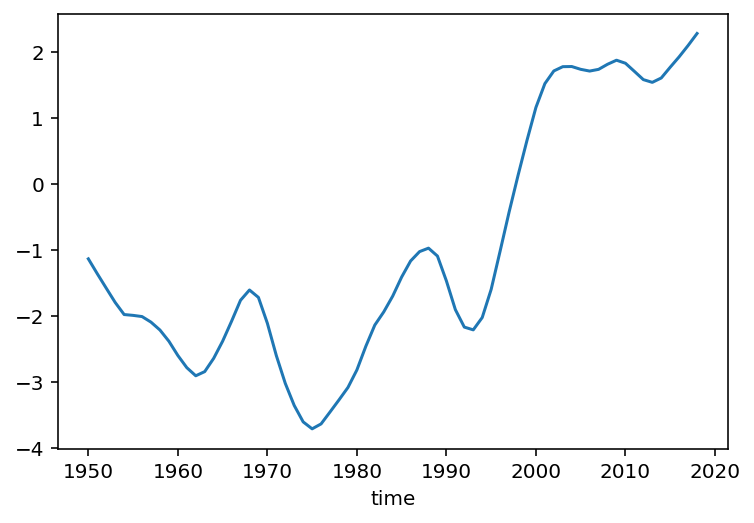

In [210]:
st['Steric'].plot()

Where does the 1961 peak difference come from?

Check the correlation pattern to select the best region for steric sea level.

Averaging IAP and EN4 seems to give the best results

### Check EN4

<AxesSubplot:xlabel='Depth'>

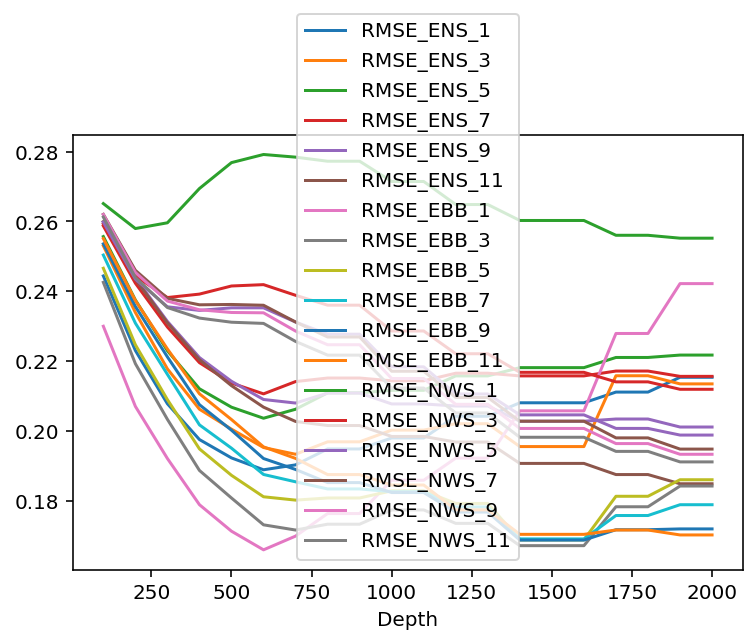

In [25]:
error_EN4_df.filter(like='RMSE').plot()

In [27]:
error_EN4_df['linear_EBB_3']

Depth
100     0.650369
200     0.548434
300     0.482027
400     0.423732
500     0.393318
600     0.345781
700     0.321235
800     0.306193
900     0.306193
1000    0.297767
1100    0.297767
1200    0.221515
1300    0.221515
1400    0.121447
1500    0.121447
1600    0.121447
1700    0.120903
1800    0.120903
1900    0.078081
2000    0.078081
Name: linear_EBB_3, dtype: float64